In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.integrate
import scipy.linalg
import math

In [129]:
df = pd.read_csv("../sampledata/shuttle.csv")
sampledata = df["0"]

In [130]:
# http://www.sciencedirect.com/science/article/pii/S0895717705004863#fd16
def moments(data, n):
    return [
        sum([x**i for x in data]) for i in range(2*n + 1)
    ]

def hankel_det(m):
    n = int((len(m) - 1) / 2)
    matrix = []
    for r in range(n+1):
        matrix.append(m[r:r+n+1])
    matrix = np.asarray(matrix)
    return np.linalg.det(matrix)

# Moments on data shifted so point of interest is 0
def max_mass_at_zero(normalized_moments):
    n = int((len(normalized_moments) - 1) / 2)
    numerator_matrix = []
    for r in range(n+1):
        numerator_matrix.append(normalized_moments[r:r+n+1])
    numerator_matrix = np.asarray(numerator_matrix)
    denominator_matrix = []
    for r in range(2, n+2):
        denominator_matrix.append(normalized_moments[r:r+n])
    denominator_matrix = np.asarray(denominator_matrix)
    p = np.linalg.det(numerator_matrix) / np.linalg.det(denominator_matrix)
    return p

# Moments on data shifted so point of interest is 0
# Question: should first moment also be subtracted by p?
def gen_orthogonal_P(normalized_moments):
    n = int((len(normalized_moments) - 1) / 2)
    scale = 1. / math.sqrt(hankel_det(normalized_moments[:-2]) * hankel_det(normalized_moments))
    
    matrix = []
    for r in range(n):
        matrix.append(normalized_moments[r:r+n+1])
    matrix = np.asarray(matrix)
        
    coefs = []
    sign = 1 if n % 2 == 0 else -1
    for i in range(n+1):
        minor = np.delete(matrix, i, axis=1)
        coefs.append(sign * (-1)**i * np.linalg.det(minor))
    
    def P(x):
        return sum([coefs[i] * x**i for i in range(n+1)])
    return P, coefs

In [131]:
def bounds(data, C, n):
    # shift data so C is 0
    data = data - C
    m = moments(data, n)
    m /= m[0]
    p = max_mass_at_zero(m)
    print("Bound size: ", p)
    P, coefs = gen_orthogonal_P(m)
    xs = np.roots(coefs[::-1])
    m[0] -= p
    A = []
    for i in range(n):
        A.append([x**i for x in xs])
    A = np.asarray(A)
    weights = np.linalg.solve(A, m[:n])
    L = 0
    for x, w in zip(xs, weights):
        if x < 0:
            L += w
    U = L + p
    print("Quantile of estimate is between: ", L, U)

In [132]:
estimate = 60.227341
bounds(sampledata, estimate, 4)

sdata = np.sort(sampledata)
print("Actual quantile: ", np.searchsorted(sdata, estimate) / len(sdata))

Bound size:  0.166425004172
Quantile of estimate is between:  0.805517997235 0.971943001407
Actual quantile:  0.936068965517


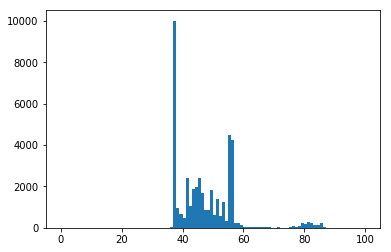

In [133]:
plt.hist(sampledata, bins=100, range=[0,100])
plt.show()